In [1]:
# General-purpose
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Torch for modeling
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Scikit-learn for preprocessing and evaluation

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import clone

# NLP tools
import spacy
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Progress bar
from tqdm import tqdm, trange
import time
import optuna
# Word cloud for visualization
from wordcloud import WordCloud



# Multi-Classifier Comparison for Fake News Detection

import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')


/home/lab/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Good things

In [2]:
df = pd.read_csv('final_data.csv')
df.head()

,title,text,Label,text_length,word_count,title_length
0,donald trump sends out embarrassing new year e...,donald trump just could not wish all american ...,0,2283,385,72
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,0,1673,248,68
2,sheriff david clarke becomes internet joke for...,friday wa revealed that former milwaukee sheri...,0,2643,422,78
3,trump obsessed even ha obama name coded into h...,christmas day donald trump announced that woul...,0,2095,338,62
4,pope francis just called out donald trump duri...,pope francis used his annual christmas day mes...,0,1990,332,69


In [3]:
# Check the distribution of labels in the final sampled dataframe
label_distribution = df['Label'].value_counts()

# Display label distribution
print("Label Distribution (Real vs Fake News):")
print(label_distribution)

# Optionally, map labels to their meaning (real vs fake)
label_mapping = {0: "Fake", 1: "Real"}
print("\nMapped Distribution:")
print(label_distribution.index.map(label_mapping))

Label Distribution (Real vs Fake News):
Label
0    51575
1    47956
Name: count, dtype: int64

Mapped Distribution:
Index(['Fake', 'Real'], dtype='object', name='Label')


In [4]:
df_0 = df[df['Label'] == 0]
df_1 = df[df['Label'] == 1]

# Sample 10,000 rows from each label (if there are enough rows)
sampled_df_0 = df_0.sample(n=10000, random_state=42, replace=False)
sampled_df_1 = df_1.sample(n=10000, random_state=42, replace=False)

# Concatenate the two sampled DataFrames
final_sampled_df = pd.concat([sampled_df_0, sampled_df_1])

# Shuffle the final dataframe to mix the labels
sample_df = final_sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

sample_df.head()


,title,text,Label,text_length,word_count,title_length
0,session persuaded trump end daca then race-bai...,certainly secret that jefferson beauregard ses...,1,2688,434,88
1,factbox you lawmaker others hospital after sho...,reuters senior member the you house representa...,0,1860,277,69
2,dr. trump offer placebo transparency the new y...,thursday episode the dr. show donald trump tol...,0,4234,676,54
3,revealed how democratic party pay agit-prop pr...,anthony brian logan james keefe project verita...,0,1179,183,81
4,trump will not ask donor repay nearly million ...,washington reuters republican donald trump ha ...,1,3998,600,59


In [5]:
spacy.cli.download("en_core_web_md")

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 10.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/lab/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
# Download necessary models
nlp = spacy.load('en_core_web_md')
# nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()


In [10]:
from sentence_transformers import SentenceTransformer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device -> {device}')
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

text_embeddings = model.encode(sample_df['text'].tolist(), show_progress_bar=True, batch_size=32, convert_to_tensor=True, device=device)

/home/lab/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device -> cpu


Batches: 100%|██████████| 625/625 [04:20<00:00,  2.40it/s]


In [11]:
torch.save({
    'text_embeddings': torch.tensor(text_embeddings)
}, 'embeddings.pth')

/tmp/ipykernel_9677/1756431424.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'text_embeddings': torch.tensor(text_embeddings)


In [8]:
# Just for loading The text_embeddings

checkpoint = torch.load('embeddings.pth')

# Retrieve embeddings
text_embeddings = checkpoint['text_embeddings']

text_embeddings = text_embeddings.numpy()

In [9]:
text_embeddings

array([[-0.15168498,  0.05076741,  0.00577738, ...,  0.03440189,
         0.01263732, -0.03231959],
       [-0.0217052 ,  0.03860647,  0.00116673, ...,  0.0101802 ,
        -0.02506239,  0.03023208],
       [-0.0302746 ,  0.09019405,  0.07663918, ...,  0.0122202 ,
        -0.03732891,  0.10030504],
       ...,
       [ 0.01327421,  0.09790859,  0.02832698, ..., -0.00722394,
         0.03223475, -0.00765299],
       [-0.04839357, -0.02018514, -0.04375871, ..., -0.0272069 ,
         0.01274508, -0.0151646 ],
       [-0.08904281,  0.09196734,  0.05890042, ..., -0.14254005,
        -0.05353836,  0.04891393]], shape=(20000, 384), dtype=float32)

In [10]:
# --- Sentence-level Preprocessing ---

def preprocess_article(text):
    doc = nlp(text)
    processed_sentences = []
    for sent in doc.sents:
        s = sent.text.strip()
        if len(s) > 1:
            processed_sentences.append({
                "original": s,
                "word_count": len(s.split())
            })
    return processed_sentences

# --- Feature Functions ---

def paraphrasing_rate(processed_sentences, T=0.8):
    embeddings = [nlp(s['original']).vector for s in processed_sentences]
    N = len(embeddings)
    if N <= 1:
        return 0.0
    count = 0
    for i in range(N):
        sims = [
            cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
            for j in range(N) if j != i
        ]
        if max(sims, default=0) > T:
            count += 1
    return count / N

def subjectivity_ratio(processed_sentences):
    N = len(processed_sentences)
    if N == 0:
        return 0.0
    subj = sum(1 for s in processed_sentences
               if TextBlob(s['original']).sentiment.subjectivity > 0.5)
    return subj / N

def sentiment_intensity_ratio(processed_sentences):
    N = len(processed_sentences)
    if N == 0:
        return 0.0
    intense = sum(1 for s in processed_sentences
                  if abs(sid.polarity_scores(s['original'])['compound']) > 0.5)
    return intense / N

def average_sentence_length(processed_sentences):
    N = len(processed_sentences)
    if N == 0:
        return 0.0
    total = sum(s['word_count'] for s in processed_sentences)
    return total / N

def manipulative_score(processed_sentences, alpha=0.5, beta=0.5):
    return alpha * subjectivity_ratio(processed_sentences) + beta * sentiment_intensity_ratio(processed_sentences)

# --- Dataset Preparation ---

def prepare_dataset(df, text_vectors, cache_path="cached_dataset.pkl"):
    if os.path.exists(cache_path):
        print(f"📦 Loading cached dataset from {cache_path} ...")
        X, y = joblib.load(cache_path)
        return X, y

    print("🔍 Preprocessing articles and generating features...")
    X, y = [], []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Preprocessing"):
        text = row['text']
        label = row['Label']
        vec = text_vectors[idx]  # already extracted 384-d vector

        processed = preprocess_article(text)
        f1 = paraphrasing_rate(processed)
        f2 = subjectivity_ratio(processed)
        f3 = sentiment_intensity_ratio(processed)
        f4 = average_sentence_length(processed)
        f5 = manipulative_score(processed)

        X.append(list(vec) + [f1, f2, f3, f4, f5])
        y.append(label)

    # Convert to tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)

    # Save to disk
    joblib.dump((X_tensor, y_tensor), cache_path)
    print(f"✅ Dataset cached at {cache_path}")

    return X_tensor, y_tensor



In [ ]:

# --- Model Definition ---
class FakeNewsClassifier(nn.Module):
    def __init__(self, input_dim=389):
        super(FakeNewsClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)  # Remove sigmoid here

# --- Training and Evaluation ---

def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    loop = tqdm(loader, desc="🛠️ Training", leave=False)
    for xb, yb in loop:
        xb, yb = xb.to(device), yb.to(device).float()
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        loop.set_postfix(loss=loss.item())
    return total_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = (model(xb) > 0.5).long()
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total

# --- Main Training Loop ---

# Replace with your real data
# dff = DataFrame with columns ['text', 'Label']
# text_embeddings = Numpy array with shape (N, 384)

X, y = prepare_dataset(sample_df, text_embeddings)


In [19]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FakeNewsClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 30
best_acc = 0
patience = 5
wait = 0


print("🏁 Starting training...\n")

for epoch in trange(epochs, desc="📊 Epoch Progress"):
    start = time.time()

    loss = train(model, train_loader, criterion, optimizer, device)
    acc = evaluate(model, test_loader, device)

    elapsed = time.time() - start
    print(f"📅 Epoch {epoch+1}/{epochs} — 🧠 Loss: {loss:.4f} | 🎯 Test Acc: {acc:.4f} | ⏱️ Time: {elapsed:.2f}s")

    if acc > best_acc:
        best_acc = acc
        wait = 0
        torch.save(model.state_dict(), "best_fake_news.pt")
        print("✅ New best model saved!")
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping triggered.")
            break
        
print(f"\n✅ Training done. Best test accuracy: {best_acc:.4f}")

🏁 Starting training...



📊 Epoch Progress:   3%|▎         | 1/30 [00:01<00:39,  1.38s/it]

📅 Epoch 1/30 — 🧠 Loss: 0.7030 | 🎯 Test Acc: 0.5142 | ⏱️ Time: 1.37s
✅ New best model saved!


📊 Epoch Progress:   7%|▋         | 2/30 [00:02<00:39,  1.40s/it]

📅 Epoch 2/30 — 🧠 Loss: 0.6948 | 🎯 Test Acc: 0.5228 | ⏱️ Time: 1.41s
✅ New best model saved!


📊 Epoch Progress:  10%|█         | 3/30 [00:04<00:37,  1.37s/it]

📅 Epoch 3/30 — 🧠 Loss: 0.6913 | 🎯 Test Acc: 0.5258 | ⏱️ Time: 1.34s
✅ New best model saved!


📊 Epoch Progress:  13%|█▎        | 4/30 [00:05<00:36,  1.39s/it]

📅 Epoch 4/30 — 🧠 Loss: 0.6909 | 🎯 Test Acc: 0.5310 | ⏱️ Time: 1.41s
✅ New best model saved!


📊 Epoch Progress:  17%|█▋        | 5/30 [00:06<00:35,  1.40s/it]

📅 Epoch 5/30 — 🧠 Loss: 0.6880 | 🎯 Test Acc: 0.5235 | ⏱️ Time: 1.43s


📊 Epoch Progress:  20%|██        | 6/30 [00:08<00:35,  1.47s/it]

📅 Epoch 6/30 — 🧠 Loss: 0.6857 | 🎯 Test Acc: 0.5240 | ⏱️ Time: 1.61s


📊 Epoch Progress:  23%|██▎       | 7/30 [00:10<00:35,  1.54s/it]

📅 Epoch 7/30 — 🧠 Loss: 0.6862 | 🎯 Test Acc: 0.5270 | ⏱️ Time: 1.67s


📊 Epoch Progress:  27%|██▋       | 8/30 [00:12<00:35,  1.62s/it]

📅 Epoch 8/30 — 🧠 Loss: 0.6857 | 🎯 Test Acc: 0.5557 | ⏱️ Time: 1.79s
✅ New best model saved!


📊 Epoch Progress:  30%|███       | 9/30 [00:13<00:35,  1.68s/it]

📅 Epoch 9/30 — 🧠 Loss: 0.6844 | 🎯 Test Acc: 0.5278 | ⏱️ Time: 1.82s


📊 Epoch Progress:  33%|███▎      | 10/30 [00:15<00:33,  1.69s/it]

📅 Epoch 10/30 — 🧠 Loss: 0.6813 | 🎯 Test Acc: 0.5510 | ⏱️ Time: 1.71s


📊 Epoch Progress:  37%|███▋      | 11/30 [00:17<00:32,  1.69s/it]

📅 Epoch 11/30 — 🧠 Loss: 0.6817 | 🎯 Test Acc: 0.5493 | ⏱️ Time: 1.68s


📊 Epoch Progress:  40%|████      | 12/30 [00:18<00:30,  1.68s/it]

📅 Epoch 12/30 — 🧠 Loss: 0.6827 | 🎯 Test Acc: 0.5483 | ⏱️ Time: 1.65s


📊 Epoch Progress:  43%|████▎     | 13/30 [00:20<00:28,  1.67s/it]

📅 Epoch 13/30 — 🧠 Loss: 0.6802 | 🎯 Test Acc: 0.5427 | ⏱️ Time: 1.67s


📊 Epoch Progress:  47%|████▋     | 14/30 [00:22<00:26,  1.67s/it]

📅 Epoch 14/30 — 🧠 Loss: 0.6786 | 🎯 Test Acc: 0.5540 | ⏱️ Time: 1.67s


📊 Epoch Progress:  50%|█████     | 15/30 [00:23<00:25,  1.69s/it]

📅 Epoch 15/30 — 🧠 Loss: 0.6780 | 🎯 Test Acc: 0.5405 | ⏱️ Time: 1.73s


📊 Epoch Progress:  53%|█████▎    | 16/30 [00:25<00:23,  1.69s/it]

📅 Epoch 16/30 — 🧠 Loss: 0.6773 | 🎯 Test Acc: 0.5460 | ⏱️ Time: 1.68s


📊 Epoch Progress:  57%|█████▋    | 17/30 [00:27<00:21,  1.69s/it]

📅 Epoch 17/30 — 🧠 Loss: 0.6778 | 🎯 Test Acc: 0.5435 | ⏱️ Time: 1.70s


📊 Epoch Progress:  60%|██████    | 18/30 [00:28<00:20,  1.68s/it]

📅 Epoch 18/30 — 🧠 Loss: 0.6769 | 🎯 Test Acc: 0.5485 | ⏱️ Time: 1.64s


📊 Epoch Progress:  63%|██████▎   | 19/30 [00:30<00:18,  1.68s/it]

📅 Epoch 19/30 — 🧠 Loss: 0.6748 | 🎯 Test Acc: 0.5455 | ⏱️ Time: 1.69s


📊 Epoch Progress:  67%|██████▋   | 20/30 [00:32<00:16,  1.68s/it]

📅 Epoch 20/30 — 🧠 Loss: 0.6731 | 🎯 Test Acc: 0.5580 | ⏱️ Time: 1.68s
✅ New best model saved!


📊 Epoch Progress:  70%|███████   | 21/30 [00:34<00:15,  1.68s/it]

📅 Epoch 21/30 — 🧠 Loss: 0.6727 | 🎯 Test Acc: 0.5510 | ⏱️ Time: 1.66s


📊 Epoch Progress:  73%|███████▎  | 22/30 [00:35<00:13,  1.67s/it]

📅 Epoch 22/30 — 🧠 Loss: 0.6729 | 🎯 Test Acc: 0.5520 | ⏱️ Time: 1.65s


📊 Epoch Progress:  77%|███████▋  | 23/30 [00:37<00:11,  1.66s/it]

📅 Epoch 23/30 — 🧠 Loss: 0.6727 | 🎯 Test Acc: 0.5500 | ⏱️ Time: 1.64s


📊 Epoch Progress:  80%|████████  | 24/30 [00:39<00:10,  1.68s/it]

📅 Epoch 24/30 — 🧠 Loss: 0.6710 | 🎯 Test Acc: 0.5343 | ⏱️ Time: 1.74s


📊 Epoch Progress:  83%|████████▎ | 25/30 [00:40<00:08,  1.70s/it]

📅 Epoch 25/30 — 🧠 Loss: 0.6710 | 🎯 Test Acc: 0.5493 | ⏱️ Time: 1.74s


📊 Epoch Progress:  87%|████████▋ | 26/30 [00:42<00:06,  1.69s/it]

📅 Epoch 26/30 — 🧠 Loss: 0.6688 | 🎯 Test Acc: 0.5505 | ⏱️ Time: 1.66s


📊 Epoch Progress:  90%|█████████ | 27/30 [00:44<00:05,  1.71s/it]

📅 Epoch 27/30 — 🧠 Loss: 0.6700 | 🎯 Test Acc: 0.5497 | ⏱️ Time: 1.74s


📊 Epoch Progress:  93%|█████████▎| 28/30 [00:45<00:03,  1.72s/it]

📅 Epoch 28/30 — 🧠 Loss: 0.6688 | 🎯 Test Acc: 0.5517 | ⏱️ Time: 1.74s


📊 Epoch Progress:  97%|█████████▋| 29/30 [00:47<00:01,  1.72s/it]

📅 Epoch 29/30 — 🧠 Loss: 0.6676 | 🎯 Test Acc: 0.5483 | ⏱️ Time: 1.73s


📊 Epoch Progress: 100%|██████████| 30/30 [00:49<00:00,  1.65s/it]


📅 Epoch 30/30 — 🧠 Loss: 0.6672 | 🎯 Test Acc: 0.5480 | ⏱️ Time: 1.71s

✅ Training done. Best test accuracy: 0.5580


In [29]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FakeNewsClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 30
best_acc = 0
patience = 5
wait = 0


print("🏁 Starting training...\n")

for epoch in trange(epochs, desc="📊 Epoch Progress"):
    start = time.time()

    loss = train(model, train_loader, criterion, optimizer, device)
    acc = evaluate(model, test_loader, device)

    elapsed = time.time() - start
    print(f"📅 Epoch {epoch+1}/{epochs} — 🧠 Loss: {loss:.4f} | 🎯 Test Acc: {acc:.4f} | ⏱️ Time: {elapsed:.2f}s")

    if acc > best_acc:
        best_acc = acc
        wait = 0
        torch.save(model.state_dict(), "best_fake_news.pt")
        print("✅ New best model saved!")
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping triggered.")
            break
        
print(f"\n✅ Training done. Best test accuracy: {best_acc:.4f}")

🏁 Starting training...



📊 Epoch Progress:   3%|▎         | 1/30 [00:01<00:32,  1.11s/it]

📅 Epoch 1/30 — 🧠 Loss: 0.7044 | 🎯 Test Acc: 0.5138 | ⏱️ Time: 1.11s
✅ New best model saved!


📊 Epoch Progress:   7%|▋         | 2/30 [00:02<00:32,  1.16s/it]

📅 Epoch 2/30 — 🧠 Loss: 0.6953 | 🎯 Test Acc: 0.5148 | ⏱️ Time: 1.19s
✅ New best model saved!


📊 Epoch Progress:  10%|█         | 3/30 [00:03<00:30,  1.14s/it]

📅 Epoch 3/30 — 🧠 Loss: 0.6921 | 🎯 Test Acc: 0.5145 | ⏱️ Time: 1.12s


📊 Epoch Progress:  13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]

📅 Epoch 4/30 — 🧠 Loss: 0.6904 | 🎯 Test Acc: 0.5160 | ⏱️ Time: 1.10s
✅ New best model saved!


📊 Epoch Progress:  17%|█▋        | 5/30 [00:05<00:29,  1.19s/it]

📅 Epoch 5/30 — 🧠 Loss: 0.6891 | 🎯 Test Acc: 0.5190 | ⏱️ Time: 1.29s
✅ New best model saved!


📊 Epoch Progress:  20%|██        | 6/30 [00:06<00:27,  1.16s/it]

📅 Epoch 6/30 — 🧠 Loss: 0.6881 | 🎯 Test Acc: 0.5142 | ⏱️ Time: 1.12s


📊 Epoch Progress:  23%|██▎       | 7/30 [00:08<00:26,  1.16s/it]

📅 Epoch 7/30 — 🧠 Loss: 0.6865 | 🎯 Test Acc: 0.5158 | ⏱️ Time: 1.15s


📊 Epoch Progress:  27%|██▋       | 8/30 [00:09<00:25,  1.16s/it]

📅 Epoch 8/30 — 🧠 Loss: 0.6850 | 🎯 Test Acc: 0.5285 | ⏱️ Time: 1.15s
✅ New best model saved!


📊 Epoch Progress:  30%|███       | 9/30 [00:10<00:24,  1.15s/it]

📅 Epoch 9/30 — 🧠 Loss: 0.6837 | 🎯 Test Acc: 0.5310 | ⏱️ Time: 1.15s
✅ New best model saved!


📊 Epoch Progress:  33%|███▎      | 10/30 [00:11<00:23,  1.16s/it]

📅 Epoch 10/30 — 🧠 Loss: 0.6832 | 🎯 Test Acc: 0.5300 | ⏱️ Time: 1.16s


📊 Epoch Progress:  37%|███▋      | 11/30 [00:12<00:21,  1.15s/it]

📅 Epoch 11/30 — 🧠 Loss: 0.6813 | 🎯 Test Acc: 0.5312 | ⏱️ Time: 1.12s
✅ New best model saved!


📊 Epoch Progress:  40%|████      | 12/30 [00:13<00:20,  1.16s/it]

📅 Epoch 12/30 — 🧠 Loss: 0.6814 | 🎯 Test Acc: 0.5292 | ⏱️ Time: 1.17s


📊 Epoch Progress:  43%|████▎     | 13/30 [00:14<00:19,  1.15s/it]

📅 Epoch 13/30 — 🧠 Loss: 0.6806 | 🎯 Test Acc: 0.5275 | ⏱️ Time: 1.13s


📊 Epoch Progress:  47%|████▋     | 14/30 [00:16<00:18,  1.15s/it]

📅 Epoch 14/30 — 🧠 Loss: 0.6790 | 🎯 Test Acc: 0.5413 | ⏱️ Time: 1.15s
✅ New best model saved!


📊 Epoch Progress:  50%|█████     | 15/30 [00:17<00:17,  1.17s/it]

📅 Epoch 15/30 — 🧠 Loss: 0.6789 | 🎯 Test Acc: 0.5275 | ⏱️ Time: 1.21s


📊 Epoch Progress:  53%|█████▎    | 16/30 [00:18<00:16,  1.16s/it]

📅 Epoch 16/30 — 🧠 Loss: 0.6777 | 🎯 Test Acc: 0.5300 | ⏱️ Time: 1.14s


📊 Epoch Progress:  57%|█████▋    | 17/30 [00:19<00:15,  1.15s/it]

📅 Epoch 17/30 — 🧠 Loss: 0.6763 | 🎯 Test Acc: 0.5343 | ⏱️ Time: 1.14s


📊 Epoch Progress:  60%|██████    | 18/30 [00:20<00:13,  1.16s/it]

📅 Epoch 18/30 — 🧠 Loss: 0.6783 | 🎯 Test Acc: 0.5390 | ⏱️ Time: 1.18s


📊 Epoch Progress:  63%|██████▎   | 19/30 [00:21<00:12,  1.17s/it]

📅 Epoch 19/30 — 🧠 Loss: 0.6756 | 🎯 Test Acc: 0.5460 | ⏱️ Time: 1.18s
✅ New best model saved!


📊 Epoch Progress:  67%|██████▋   | 20/30 [00:23<00:11,  1.20s/it]

📅 Epoch 20/30 — 🧠 Loss: 0.6747 | 🎯 Test Acc: 0.5228 | ⏱️ Time: 1.28s


📊 Epoch Progress:  70%|███████   | 21/30 [00:24<00:11,  1.29s/it]

📅 Epoch 21/30 — 🧠 Loss: 0.6752 | 🎯 Test Acc: 0.5345 | ⏱️ Time: 1.49s


📊 Epoch Progress:  73%|███████▎  | 22/30 [00:26<00:10,  1.33s/it]

📅 Epoch 22/30 — 🧠 Loss: 0.6726 | 🎯 Test Acc: 0.5397 | ⏱️ Time: 1.42s


📊 Epoch Progress:  77%|███████▋  | 23/30 [00:27<00:09,  1.36s/it]

📅 Epoch 23/30 — 🧠 Loss: 0.6744 | 🎯 Test Acc: 0.5390 | ⏱️ Time: 1.43s


📊 Epoch Progress:  80%|████████  | 24/30 [00:29<00:08,  1.37s/it]

📅 Epoch 24/30 — 🧠 Loss: 0.6730 | 🎯 Test Acc: 0.5477 | ⏱️ Time: 1.41s
✅ New best model saved!


📊 Epoch Progress:  83%|████████▎ | 25/30 [00:30<00:06,  1.39s/it]

📅 Epoch 25/30 — 🧠 Loss: 0.6723 | 🎯 Test Acc: 0.5407 | ⏱️ Time: 1.42s


📊 Epoch Progress:  87%|████████▋ | 26/30 [00:31<00:05,  1.40s/it]

📅 Epoch 26/30 — 🧠 Loss: 0.6704 | 🎯 Test Acc: 0.5403 | ⏱️ Time: 1.42s


📊 Epoch Progress:  90%|█████████ | 27/30 [00:33<00:04,  1.40s/it]

📅 Epoch 27/30 — 🧠 Loss: 0.6712 | 🎯 Test Acc: 0.5403 | ⏱️ Time: 1.40s


📊 Epoch Progress:  93%|█████████▎| 28/30 [00:34<00:02,  1.40s/it]

📅 Epoch 28/30 — 🧠 Loss: 0.6689 | 🎯 Test Acc: 0.5387 | ⏱️ Time: 1.41s


📊 Epoch Progress:  97%|█████████▋| 29/30 [00:36<00:01,  1.41s/it]

📅 Epoch 29/30 — 🧠 Loss: 0.6695 | 🎯 Test Acc: 0.5503 | ⏱️ Time: 1.43s
✅ New best model saved!


📊 Epoch Progress: 100%|██████████| 30/30 [00:37<00:00,  1.25s/it]

📅 Epoch 30/30 — 🧠 Loss: 0.6709 | 🎯 Test Acc: 0.5302 | ⏱️ Time: 1.40s

✅ Training done. Best test accuracy: 0.5503


In [23]:
def objective(trial):
    hidden1 = trial.suggest_int("hidden1", 256, 1024)
    hidden2 = trial.suggest_int("hidden2", 128, 512)
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    class TrialModel(nn.Module):
        def __init__(self, input_dim=389):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden1),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden1, hidden2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden2, 1)
            )

        def forward(self, x):
            return self.net(x).squeeze(1)

    model = TrialModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # one epoch for speed (increase if needed)
    train(model, train_loader, criterion, optimizer, device)
    acc = evaluate(model, test_loader, device)
    return acc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)


print("🔍 Best hyperparams:", study.best_params)

[I 2025-06-23 11:10:38,316] A new study created in memory with name: no-name-0f25f17d-1815-4afa-9b03-cbe4401a1c59
[I 2025-06-23 11:10:39,097] Trial 0 finished with value: 0.51375 and parameters: {'hidden1': 263, 'hidden2': 206, 'dropout': 0.3551078423514453, 'lr': 0.002148514716580759}. Best is trial 0 with value: 0.51375.
[I 2025-06-23 11:10:40,556] Trial 1 finished with value: 0.51325 and parameters: {'hidden1': 748, 'hidden2': 448, 'dropout': 0.27022359692632575, 'lr': 0.00013905422669027197}. Best is trial 0 with value: 0.51375.
[I 2025-06-23 11:10:41,569] Trial 2 finished with value: 0.51375 and parameters: {'hidden1': 696, 'hidden2': 223, 'dropout': 0.2374188795441647, 'lr': 0.0003415413430920346}. Best is trial 0 with value: 0.51375.
[I 2025-06-23 11:10:42,608] Trial 3 finished with value: 0.51375 and parameters: {'hidden1': 326, 'hidden2': 374, 'dropout': 0.400344898037102, 'lr': 0.0013005795378793516}. Best is trial 0 with value: 0.51375.
[I 2025-06-23 11:10:43,601] Trial 4 fi

🔍 Best hyperparams: {'hidden1': 364, 'hidden2': 456, 'dropout': 0.4849377999386608, 'lr': 0.00020915529583129307}


In [28]:
# === Configurable Section ===
best_params = {
    'hidden1': 364,
    'hidden2': 456,
    'dropout': 0.4849377999386608,
    'lr': 0.00020915529583129307,
    'batch_size': 32,
    'epochs': 50,
    'patience': 5
}

# --- Model Definition ---
class FakeNewsClassifier(nn.Module):
    def __init__(self, input_dim=389, hidden1=256, hidden2=128, dropout=0.4):
        super(FakeNewsClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

# --- Training Logic ---
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    loop = tqdm(loader, desc="🛠️ Training", leave=False)
    for xb, yb in loop:
        xb, yb = xb.to(device), yb.to(device).float()
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        loop.set_postfix(loss=loss.item())
    return total_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = (model(xb) > 0.5).long()
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total

# --- Runner Function ---
def run_training(df, text_vectors, params=best_params):
    print("📦 Preparing dataset...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=params['batch_size'], shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=params['batch_size'])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FakeNewsClassifier(
        input_dim=X.shape[1],
        hidden1=params['hidden1'],
        hidden2=params['hidden2'],
        dropout=params['dropout']
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.BCEWithLogitsLoss()

    best_acc = 0
    wait = 0

    print("🏁 Starting training...\n")
    for epoch in trange(params['epochs'], desc="📊 Epoch Progress"):
        start = time.time()

        loss = train(model, train_loader, criterion, optimizer, device)
        acc = evaluate(model, test_loader, device)

        elapsed = time.time() - start
        print(f"📅 Epoch {epoch+1}/{params['epochs']} — 🧠 Loss: {loss:.4f} | 🎯 Test Acc: {acc:.4f} | ⏱️ Time: {elapsed:.2f}s")

        if acc > best_acc:
            best_acc = acc
            wait = 0
            torch.save(model.state_dict(), "best_fake_news.pt")
            print("✅ New best model saved!")
        else:
            wait += 1
            if wait >= params['patience']:
                print("⏹️ Early stopping triggered.")
                break

    print(f"\n✅ Training done. Best test accuracy: {best_acc:.4f}")
    return model

# === Inference Helper (Optional) ===
def predict(model, X_tensor, threshold=0.5):
    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(X_tensor))
        return (probs > threshold).long()
    

model = run_training(sample_df, text_embeddings)


📦 Preparing dataset...
🏁 Starting training...



📊 Epoch Progress:   2%|▏         | 1/50 [00:01<01:07,  1.37s/it]

📅 Epoch 1/50 — 🧠 Loss: 0.7165 | 🎯 Test Acc: 0.5138 | ⏱️ Time: 1.37s
✅ New best model saved!


📊 Epoch Progress:   4%|▍         | 2/50 [00:02<01:05,  1.37s/it]

📅 Epoch 2/50 — 🧠 Loss: 0.7071 | 🎯 Test Acc: 0.5135 | ⏱️ Time: 1.36s


📊 Epoch Progress:   6%|▌         | 3/50 [00:04<01:04,  1.37s/it]

📅 Epoch 3/50 — 🧠 Loss: 0.7019 | 🎯 Test Acc: 0.5138 | ⏱️ Time: 1.37s


📊 Epoch Progress:   8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

📅 Epoch 4/50 — 🧠 Loss: 0.6972 | 🎯 Test Acc: 0.5162 | ⏱️ Time: 1.36s
✅ New best model saved!


📊 Epoch Progress:  10%|█         | 5/50 [00:06<01:01,  1.38s/it]

📅 Epoch 5/50 — 🧠 Loss: 0.6933 | 🎯 Test Acc: 0.5210 | ⏱️ Time: 1.39s
✅ New best model saved!


📊 Epoch Progress:  12%|█▏        | 6/50 [00:08<01:01,  1.39s/it]

📅 Epoch 6/50 — 🧠 Loss: 0.6901 | 🎯 Test Acc: 0.5238 | ⏱️ Time: 1.41s
✅ New best model saved!


📊 Epoch Progress:  14%|█▍        | 7/50 [00:09<00:59,  1.39s/it]

📅 Epoch 7/50 — 🧠 Loss: 0.6873 | 🎯 Test Acc: 0.5182 | ⏱️ Time: 1.40s


📊 Epoch Progress:  16%|█▌        | 8/50 [00:11<00:58,  1.39s/it]

📅 Epoch 8/50 — 🧠 Loss: 0.6861 | 🎯 Test Acc: 0.5220 | ⏱️ Time: 1.39s


📊 Epoch Progress:  18%|█▊        | 9/50 [00:12<00:56,  1.38s/it]

📅 Epoch 9/50 — 🧠 Loss: 0.6857 | 🎯 Test Acc: 0.5278 | ⏱️ Time: 1.35s
✅ New best model saved!


📊 Epoch Progress:  20%|██        | 10/50 [00:13<00:55,  1.39s/it]

📅 Epoch 10/50 — 🧠 Loss: 0.6847 | 🎯 Test Acc: 0.5235 | ⏱️ Time: 1.42s


📊 Epoch Progress:  22%|██▏       | 11/50 [00:15<01:00,  1.54s/it]

📅 Epoch 11/50 — 🧠 Loss: 0.6832 | 🎯 Test Acc: 0.5235 | ⏱️ Time: 1.88s


📊 Epoch Progress:  24%|██▍       | 12/50 [00:17<00:59,  1.57s/it]

📅 Epoch 12/50 — 🧠 Loss: 0.6830 | 🎯 Test Acc: 0.5280 | ⏱️ Time: 1.64s
✅ New best model saved!


📊 Epoch Progress:  26%|██▌       | 13/50 [00:18<00:56,  1.53s/it]

📅 Epoch 13/50 — 🧠 Loss: 0.6815 | 🎯 Test Acc: 0.5308 | ⏱️ Time: 1.43s
✅ New best model saved!


📊 Epoch Progress:  28%|██▊       | 14/50 [00:20<00:54,  1.52s/it]

📅 Epoch 14/50 — 🧠 Loss: 0.6806 | 🎯 Test Acc: 0.5353 | ⏱️ Time: 1.49s
✅ New best model saved!


📊 Epoch Progress:  30%|███       | 15/50 [00:21<00:52,  1.50s/it]

📅 Epoch 15/50 — 🧠 Loss: 0.6798 | 🎯 Test Acc: 0.5312 | ⏱️ Time: 1.47s


📊 Epoch Progress:  32%|███▏      | 16/50 [00:23<00:51,  1.51s/it]

📅 Epoch 16/50 — 🧠 Loss: 0.6794 | 🎯 Test Acc: 0.5252 | ⏱️ Time: 1.51s


📊 Epoch Progress:  34%|███▍      | 17/50 [00:24<00:50,  1.52s/it]

📅 Epoch 17/50 — 🧠 Loss: 0.6792 | 🎯 Test Acc: 0.5335 | ⏱️ Time: 1.56s


📊 Epoch Progress:  36%|███▌      | 18/50 [00:26<00:50,  1.59s/it]

📅 Epoch 18/50 — 🧠 Loss: 0.6775 | 🎯 Test Acc: 0.5327 | ⏱️ Time: 1.73s


📊 Epoch Progress:  38%|███▊      | 19/50 [00:28<00:50,  1.63s/it]

📅 Epoch 19/50 — 🧠 Loss: 0.6780 | 🎯 Test Acc: 0.5417 | ⏱️ Time: 1.74s
✅ New best model saved!


📊 Epoch Progress:  40%|████      | 20/50 [00:30<00:50,  1.67s/it]

📅 Epoch 20/50 — 🧠 Loss: 0.6773 | 🎯 Test Acc: 0.5325 | ⏱️ Time: 1.76s


📊 Epoch Progress:  42%|████▏     | 21/50 [00:31<00:48,  1.68s/it]

📅 Epoch 21/50 — 🧠 Loss: 0.6776 | 🎯 Test Acc: 0.5390 | ⏱️ Time: 1.70s


📊 Epoch Progress:  44%|████▍     | 22/50 [00:33<00:47,  1.70s/it]

📅 Epoch 22/50 — 🧠 Loss: 0.6767 | 🎯 Test Acc: 0.5323 | ⏱️ Time: 1.74s


📊 Epoch Progress:  46%|████▌     | 23/50 [00:35<00:45,  1.69s/it]

📅 Epoch 23/50 — 🧠 Loss: 0.6756 | 🎯 Test Acc: 0.5343 | ⏱️ Time: 1.68s


📊 Epoch Progress:  46%|████▌     | 23/50 [00:36<00:43,  1.60s/it]

📅 Epoch 24/50 — 🧠 Loss: 0.6744 | 🎯 Test Acc: 0.5373 | ⏱️ Time: 1.69s
⏹️ Early stopping triggered.

✅ Training done. Best test accuracy: 0.5417


## Training Multiple Classifiers

🚀 Starting Multi-Classifier Comparison for Fake News Detection


🔍 Preprocessing articles:   0%|          | 0/20000 [00:00<?, ?it/s]

🔍 Preprocessing articles: 100%|██████████| 20000/20000 [21:09<00:00, 15.75it/s] 


📊 Dataset Info:
   • Total samples: 20000
   • Features: 389
   • Fake news: 10000
   • Real news: 10000



XGBoost Training:   0%|          | 0/100 [00:00<?, ?it/s]


🔄 [1/6] Training 🔵 Logistic Regression (Linear baseline classifier)...
   🔁 Cross-validation:


   ⏳ CV Progress: 100%|██████████| 5/5 [00:27<00:00,  5.49s/it]


   ✅ Accuracy: 0.5493
   📊 CV Score: 0.5612 (±0.0061)

🔄 [2/6] Training 🟣 Random Forest (Ensemble method for non-linear patterns)...
   🔁 Cross-validation:


XGBoost Training:   1%|          | 1/100 [00:46<1:16:21, 46.28s/it]

   ✅ Accuracy: 0.4840
   📊 CV Score: 0.5019 (±0.0115)

🔄 [3/6] Training 🔶 XGBoost (Gradient boosting for mixed features)...


XGBoost Training: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


   ❌ Error with 🔶 XGBoost: after_training should return the model

🔄 [3/6] Training 🟢 SVM (RBF) (Support Vector Machine with RBF kernel)...
   🔁 Cross-validation:


   ⏳ CV Progress: 100%|██████████| 5/5 [10:52<00:00, 130.50s/it]


   ✅ Accuracy: 0.5262
   📊 CV Score: 0.5451 (±0.0040)

🔄 [4/6] Training 🟢 SVM (Linear) (Linear Support Vector Machine)...
   🔁 Cross-validation:


   ⏳ CV Progress: 100%|██████████| 5/5 [20:06:39<00:00, 14479.90s/it]  


   ✅ Accuracy: 0.5507
   📊 CV Score: 0.5565 (±0.0071)

🔄 [5/6] Training 🟠 Gaussian Naive Bayes (Probabilistic classifier)...
   🔁 Cross-validation:


   ⏳ CV Progress: 100%|██████████| 5/5 [00:00<00:00, 31.87it/s]


   ✅ Accuracy: 0.5420
   📊 CV Score: 0.5494 (±0.0085)

🔥 Training Transformer-Based Classifier (DistilBERT)...

📈 FINAL RESULTS COMPARISON

🏆 RANKING BY ACCURACY:
--------------------------------------------------------------------------------
 5. 🟢 SVM (Linear)                 Acc: 0.5507 | F1: 0.5452 | Prec: 0.5520 | Recall: 0.5385
 4. 🔵 Logistic Regression          Acc: 0.5493 | F1: 0.5491 | Prec: 0.5493 | Recall: 0.5490
 3. 🟠 Gaussian Naive Bayes         Acc: 0.5420 | F1: 0.5300 | Prec: 0.5443 | Recall: 0.5165
 2. 🟢 SVM (RBF)                    Acc: 0.5262 | F1: 0.5155 | Prec: 0.5275 | Recall: 0.5040
 1. 🟣 Random Forest                Acc: 0.4840 | F1: 0.4748 | Prec: 0.4834 | Recall: 0.4665

📊 DETAILED METRICS:
--------------------------------------------------------------------------------
            Classifier  Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std
        🟢 SVM (Linear)    0.5507     0.5520  0.5385    0.5452   0.5565  0.0071
 🔵 Logistic Regression    0.5493    

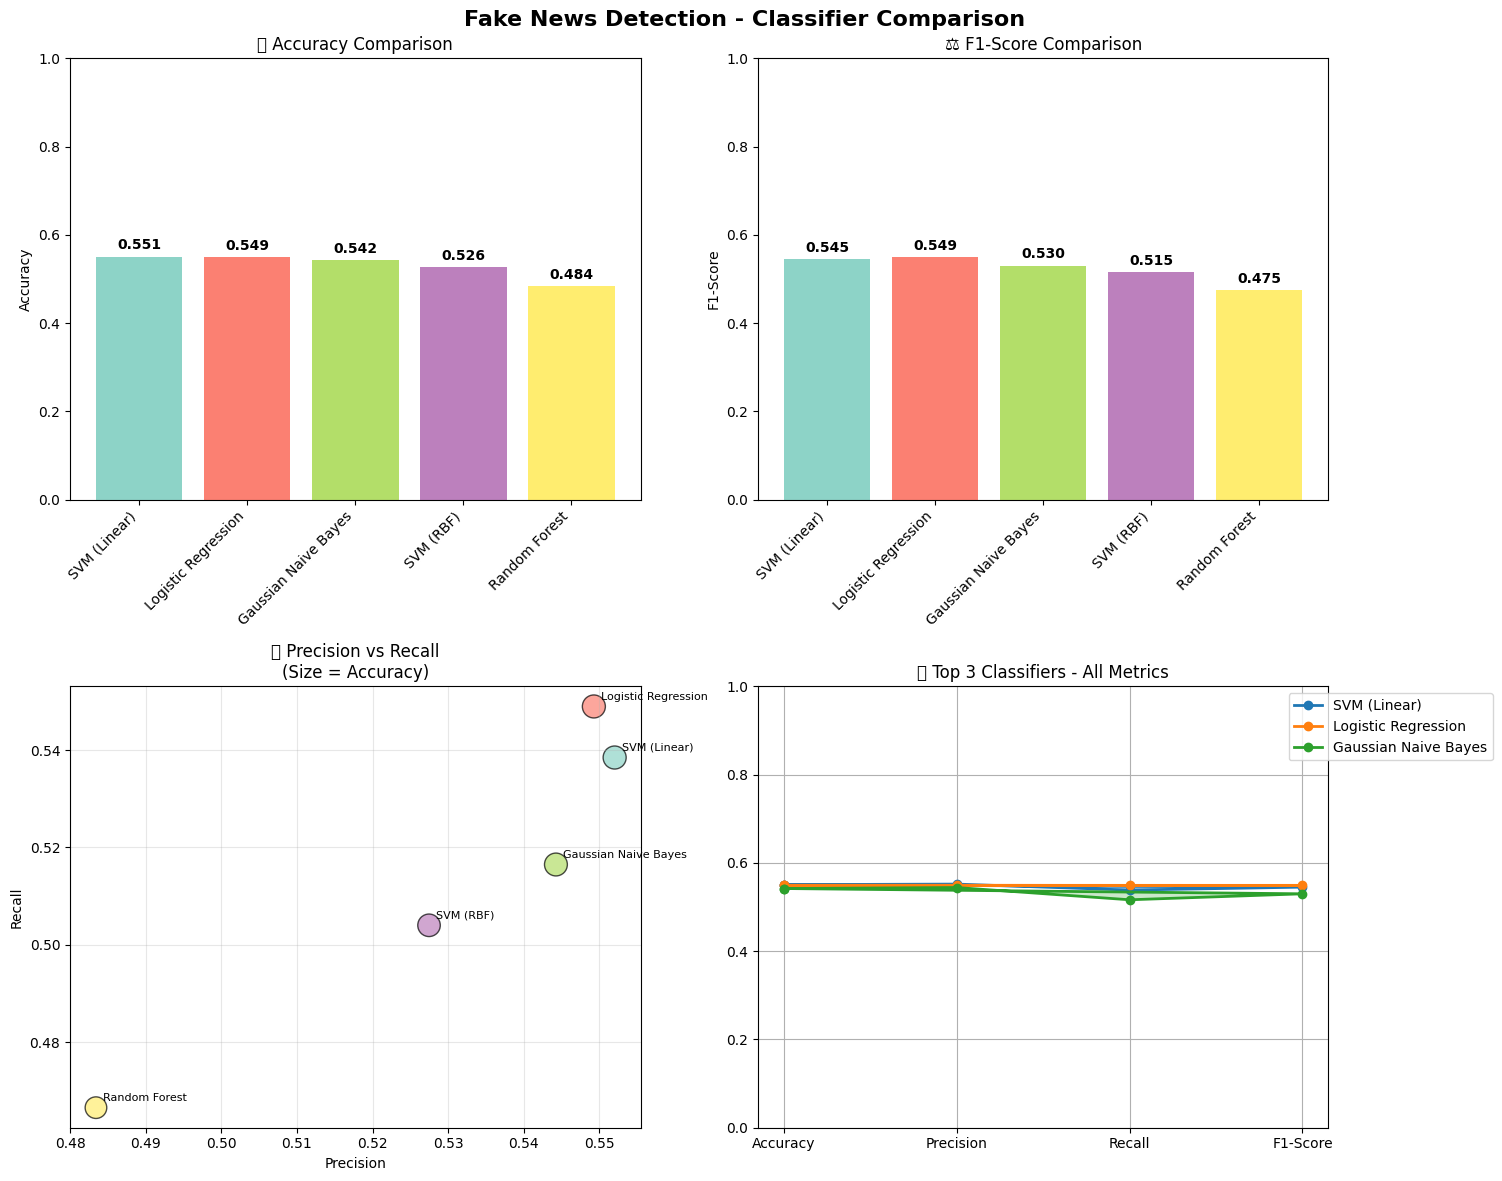


💡 RECOMMENDATIONS & INSIGHTS

🏆 BEST PERFORMER: 🟢 SVM (Linear)
   • Accuracy: 0.5507
   • F1-Score: 0.5452
   • Description: Linear Support Vector Machine

🔍 ANALYSIS:
   🔴 Low Performers (<65%): 🟢 SVM (Linear), 🔵 Logistic Regression, 🟠 Gaussian Naive Bayes, 🟢 SVM (RBF), 🟣 Random Forest

🚀 NEXT STEPS:
   1. Fine-tune hyperparameters for top 3 performers
   2. Try ensemble methods combining best classifiers
   3. Engineer additional features based on linguistic analysis
   4. Consider fine-tuning BERT/RoBERTa on your specific dataset
   5. Analyze misclassified examples for pattern insights

⚡ QUICK WINS:
   • Your custom features (paraphrasing, subjectivity, etc.) are valuable!
   • Consider feature selection to remove less important features
   • Try different text preprocessing approaches
   • Experiment with different embedding models (sentence-transformers)

✅ ANALYSIS COMPLETE! Check the visualizations above.


In [12]:
# =============================================================================
# STEP 1: PREPARE DATA
# =============================================================================

print("🚀 Starting Multi-Classifier Comparison for Fake News Detection")
print("=" * 60)

# Assuming you have your df and text_vectors ready
# X, y = prepare_dataset(sample_df, text_embeddings)  # Your existing function

# Convert to numpy for sklearn compatibility
X_np = X.numpy()
y_np = y.numpy()

print(f"📊 Dataset Info:")
print(f"   • Total samples: {len(X_np)}")
print(f"   • Features: {X_np.shape[1]}")
print(f"   • Fake news: {sum(y_np == 1)}")
print(f"   • Real news: {sum(y_np == 0)}")
print()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42, stratify=y_np
)

# =============================================================================
# STEP 2: FEATURE SCALING (for some algorithms)
# =============================================================================

scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

X_train_scaled = scaler_standard.fit_transform(X_train)
X_test_scaled = scaler_standard.transform(X_test)

X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)



from xgboost.callback import TrainingCallback

class TQDMCallback(TrainingCallback):
    def __init__(self, total_boost_rounds):
        self.pbar = tqdm(total=total_boost_rounds, desc="XGBoost Training")

    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        return False

    def after_training(self, model):
        self.pbar.close()
        return model  
# =============================================================================
# STEP 3: CLASSIFIER DEFINITIONS
# =============================================================================

classifiers = {
    "🔵 Logistic Regression": {
        "model": LogisticRegression(random_state=42, max_iter=1000),
        "data": "scaled",
        "description": "Linear baseline classifier"
    },
    
    "🟣 Random Forest": {
        "model": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        "data": "original",
        "description": "Ensemble method for non-linear patterns"
    },
    
    "🔶 XGBoost": {
        "model": xgb.XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=42,
            eval_metric='logloss',
            use_label_encoder=False,
            callbacks=[TQDMCallback(total_boost_rounds=100)]
        ),
        "data": "original",
        "description": "Gradient boosting for mixed features"
    },
    
    "🟢 SVM (RBF)": {
        "model": SVC(kernel='rbf', random_state=42, probability=True),
        "data": "scaled",
        "description": "Support Vector Machine with RBF kernel"
    },
    
    "🟢 SVM (Linear)": {
        "model": SVC(kernel='linear', random_state=42, probability=True),
        "data": "scaled",
        "description": "Linear Support Vector Machine"
    },
    
    "🟠 Gaussian Naive Bayes": {
        "model": GaussianNB(),
        "data": "minmax",
        "description": "Probabilistic classifier"
    }
}

# =============================================================================
# STEP 4: TRAINING AND EVALUATION
# =============================================================================

results = []

def evaluate_classifier(name, model, X_train_data, X_test_data, y_train, y_test):
    print(f"\n🔄 [{len(results)+1}/{len(classifiers)}] Training {name} ({config['description']})...")
 
    # Train the model
    model.fit(X_train_data, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_data)
    y_pred_proba = model.predict_proba(X_test_data)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("   🔁 Cross-validation:")
    cv_scores = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in tqdm(cv.split(X_train_data, y_train), total=5, desc="   ⏳ CV Progress"):
        model_clone = clone(model)
        model_clone.fit(X_train_data[train_idx], y_train[train_idx])
        score = model_clone.score(X_train_data[val_idx], y_train[val_idx])
        cv_scores.append(score)

    cv_scores = np.array(cv_scores)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    
    print(f"   ✅ Accuracy: {accuracy:.4f}")
    print(f"   📊 CV Score: {cv_mean:.4f} (±{cv_std:.4f})")
    
    return {
        'Classifier': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'CV_Mean': cv_mean,
        'CV_Std': cv_std,
        'Predictions': y_pred,
        'Probabilities': y_pred_proba
    }

# Train and evaluate all classifiers
for name, config in classifiers.items():
    model = config["model"]
    data_type = config["data"]
    
    # Select appropriate data
    if data_type == "scaled":
        X_train_data, X_test_data = X_train_scaled, X_test_scaled
    elif data_type == "minmax":
        X_train_data, X_test_data = X_train_minmax, X_test_minmax
    else:  # original
        X_train_data, X_test_data = X_train, X_test
    
    try:
        result = evaluate_classifier(name, model, X_train_data, X_test_data, y_train, y_test)
        result['Description'] = config["description"]
        results.append(result)
    except Exception as e:
        print(f"   ❌ Error with {name}: {str(e)}")

# =============================================================================
# STEP 5: TRANSFORMER-BASED CLASSIFIER (BERT)
# =============================================================================

print(f"\n🔥 Training Transformer-Based Classifier (DistilBERT)...")

try:
    # Prepare text data for BERT (assuming you have the original text)
    # You'll need to modify this part based on how your original text is stored
    
    # For demonstration, let's assume you have df with 'text' column
    train_texts = df.iloc[X_train.index]['text'].tolist() if hasattr(X_train, 'index') else []
    test_texts = df.iloc[X_test.index]['text'].tolist() if hasattr(X_test, 'index') else []
    
    if len(train_texts) > 0:  # Only if we have text data
        from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
        
        # Use a lightweight model for faster training
        model_name = "distilbert-base-uncased"
        classifier = pipeline("text-classification", 
                            model=model_name, 
                            return_all_scores=True)
        
        # This is a simplified approach - for better results, you'd want to fine-tune
        print("   ⚠️  Using pre-trained DistilBERT (not fine-tuned on your data)")
        print("   💡 For best results, consider fine-tuning on your specific dataset")
        
        # Sample a subset for faster evaluation
        sample_size = min(1000, len(test_texts))
        sample_indices = np.random.choice(len(test_texts), sample_size, replace=False)
        sample_texts = [test_texts[i] for i in sample_indices]
        sample_labels = y_test[sample_indices]
        
        # Get predictions (this might take a while)
        bert_predictions = []
        for text in tqdm(sample_texts[:100], desc="🤖 BERT Inference"):  # Limit to 100 for demo
            result = classifier(text[:512])  # Truncate long texts
            # Assuming label 1 is fake news
            fake_score = result[0]['score'] if result[0]['label'] == 'NEGATIVE' else result[1]['score']
            bert_predictions.append(1 if fake_score > 0.5 else 0)
        
        if len(bert_predictions) > 0:
            bert_accuracy = accuracy_score(sample_labels[:len(bert_predictions)], bert_predictions)
            print(f"   ✅ BERT Accuracy (sample): {bert_accuracy:.4f}")
            
            results.append({
                'Classifier': '🔥 DistilBERT (Pre-trained)',
                'Accuracy': bert_accuracy,
                'Precision': precision_score(sample_labels[:len(bert_predictions)], bert_predictions),
                'Recall': recall_score(sample_labels[:len(bert_predictions)], bert_predictions),
                'F1-Score': f1_score(sample_labels[:len(bert_predictions)], bert_predictions),
                'CV_Mean': None,
                'CV_Std': None,
                'Description': 'Pre-trained transformer (sample evaluation)'
            })
        
except Exception as e:
    print(f"   ❌ BERT classifier failed: {str(e)}")
    print("   💡 Make sure transformers library is installed: pip install transformers")

# =============================================================================
# STEP 6: RESULTS COMPARISON
# =============================================================================

print("\n" + "="*80)
print("📈 FINAL RESULTS COMPARISON")
print("="*80)

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

# Display results table
print("\n🏆 RANKING BY ACCURACY:")
print("-" * 80)
for idx, row in results_df.iterrows():
    print(f"{len(results_df) - list(results_df.index).index(idx):2d}. {row['Classifier']:<30} "
          f"Acc: {row['Accuracy']:.4f} | "
          f"F1: {row['F1-Score']:.4f} | "
          f"Prec: {row['Precision']:.4f} | "
          f"Recall: {row['Recall']:.4f}")

print(f"\n📊 DETAILED METRICS:")
print("-" * 80)
display_cols = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV_Mean', 'CV_Std']
print(results_df[display_cols].to_string(index=False, float_format='%.4f'))

# =============================================================================
# STEP 7: VISUALIZATION
# =============================================================================

print(f"\n📊 Creating visualizations...")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Fake News Detection - Classifier Comparison', fontsize=16, fontweight='bold')

# 1. Accuracy Comparison
ax1 = axes[0, 0]
classifiers_clean = [name.split(' ', 1)[1] if ' ' in name else name for name in results_df['Classifier']]
colors = plt.cm.Set3(np.linspace(0, 1, len(results_df)))
bars1 = ax1.bar(range(len(results_df)), results_df['Accuracy'], color=colors)
ax1.set_title('🎯 Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(range(len(results_df)))
ax1.set_xticklabels(classifiers_clean, rotation=45, ha='right')
ax1.set_ylim(0, 1)

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. F1-Score Comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(range(len(results_df)), results_df['F1-Score'], color=colors)
ax2.set_title('⚖️ F1-Score Comparison')
ax2.set_ylabel('F1-Score')
ax2.set_xticks(range(len(results_df)))
ax2.set_xticklabels(classifiers_clean, rotation=45, ha='right')
ax2.set_ylim(0, 1)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Precision vs Recall
ax3 = axes[1, 0]
scatter = ax3.scatter(results_df['Precision'], results_df['Recall'], 
                     s=results_df['Accuracy']*500, c=colors, alpha=0.7, edgecolors='black')
ax3.set_title('🎯 Precision vs Recall\n(Size = Accuracy)')
ax3.set_xlabel('Precision')
ax3.set_ylabel('Recall')
ax3.grid(True, alpha=0.3)

# Add classifier labels
for i, row in results_df.iterrows():
    ax3.annotate(classifiers_clean[list(results_df.index).index(i)], 
                (row['Precision'], row['Recall']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 4. All Metrics Radar Chart (for top 3 classifiers)
ax4 = axes[1, 1]
top_3 = results_df.head(3)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, (idx, row) in enumerate(top_3.iterrows()):
    values = [row[metric] for metric in metrics]
    values += values[:1]  # Complete the circle
    
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]
    
    ax4.plot(angles, values, 'o-', linewidth=2, label=classifiers_clean[list(results_df.index).index(idx)])
    ax4.fill(angles, values, alpha=0.25)

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(metrics)
ax4.set_ylim(0, 1)
ax4.set_title('🕸️ Top 3 Classifiers - All Metrics')
ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax4.grid(True)

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 8: RECOMMENDATIONS
# =============================================================================

print("\n" + "="*80)
print("💡 RECOMMENDATIONS & INSIGHTS")
print("="*80)

best_classifier = results_df.iloc[0]
print(f"\n🏆 BEST PERFORMER: {best_classifier['Classifier']}")
print(f"   • Accuracy: {best_classifier['Accuracy']:.4f}")
print(f"   • F1-Score: {best_classifier['F1-Score']:.4f}")
print(f"   • Description: {best_classifier['Description']}")

print(f"\n🔍 ANALYSIS:")

# Performance categories
high_performers = results_df[results_df['Accuracy'] >= 0.75]
medium_performers = results_df[(results_df['Accuracy'] >= 0.65) & (results_df['Accuracy'] < 0.75)]
low_performers = results_df[results_df['Accuracy'] < 0.65]

if len(high_performers) > 0:
    print(f"   🟢 High Performers (≥75%): {', '.join(high_performers['Classifier'].tolist())}")

if len(medium_performers) > 0:
    print(f"   🟡 Medium Performers (65-75%): {', '.join(medium_performers['Classifier'].tolist())}")

if len(low_performers) > 0:
    print(f"   🔴 Low Performers (<65%): {', '.join(low_performers['Classifier'].tolist())}")

print(f"\n🚀 NEXT STEPS:")
print(f"   1. Fine-tune hyperparameters for top 3 performers")
print(f"   2. Try ensemble methods combining best classifiers")
print(f"   3. Engineer additional features based on linguistic analysis")
print(f"   4. Consider fine-tuning BERT/RoBERTa on your specific dataset")
print(f"   5. Analyze misclassified examples for pattern insights")

print(f"\n⚡ QUICK WINS:")
print(f"   • Your custom features (paraphrasing, subjectivity, etc.) are valuable!")
print(f"   • Consider feature selection to remove less important features")
print(f"   • Try different text preprocessing approaches")
print(f"   • Experiment with different embedding models (sentence-transformers)")

print(f"\n" + "="*80)
print("✅ ANALYSIS COMPLETE! Check the visualizations above.")
print("="*80)